# F1 Lap Time Prediction (FastF1)

Mini project: predicting lap time (**LapTime**) using a small set of contextual features from FastF1:
- Driver, Tyre Compound, TyreLife, LapNumber (+ TyreLifeSquared)

Goal: demonstrate an end-to-end ML pipeline on engineering-style data (load → EDA → baseline → models → fair validation → error analysis).

This is a compact baseline focused on clean validation and interpretability.

## Project Motivation

Formula 1 is one of the most data-intensive engineering environments in the world.
Race performance depends on small time differences influenced by tyre degradation, driver behavior, and track conditions.

Coming from a pharmacy background, I was trained to think in terms of systems, variability, and measurable outcomes.
Exploring Formula 1 data allowed me to apply and further develop that analytical mindset in an engineering context.

This project reflects my effort to develop practical machine learning skills and apply them to real-world engineering data.

It helped me better understand how models behave under realistic validation and how feature design and evaluation choices affect performance.

In [1]:
!pip install -q fastf1

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import fastf1
import fastf1.plotting

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

In [3]:
cache_dir = "./fastf1_cache"
os.makedirs(cache_dir, exist_ok=True)
fastf1.Cache.enable_cache(cache_dir)

print("Cache enabled:", os.path.abspath(cache_dir))

Cache enabled: /content/fastf1_cache


## 1) Data loading

FastF1 provides per-lap records for each session.  
Here I load multiple races from the 2023 season and combine their lap tables into a single dataset.

In [4]:
def load_race_laps(year: int, gp_name: str, session_code: str = "R") -> pd.DataFrame:
    """
    session_code: 'R' race, 'Q' qualifying, 'FP1/FP2/FP3' practice
    """
    session = fastf1.get_session(year, gp_name, session_code)
    session.load()

    laps = session.laps.copy()

    laps["Year"] = year
    laps["EventName"] = session.event["EventName"]
    laps["SessionName"] = session.name
    return laps

In [5]:
import logging
logging.getLogger("fastf1").setLevel(logging.ERROR)
logging.getLogger("fastf1.ergast").setLevel(logging.ERROR)

races = [
    (2023, "Bahrain", "R"),
    (2023, "Saudi Arabia", "R"),
    (2023, "Australia", "R"),
]

all_laps = []
for y, gp, s in races:
    df = load_race_laps(y, gp, s)
    all_laps.append(df)
    print(f"Loaded: {y} {gp} {s} | laps: {len(df)}")


laps_raw = pd.concat(all_laps, ignore_index=True)
laps_raw.shape

Loaded: 2023 Bahrain R | laps: 1056
Loaded: 2023 Saudi Arabia R | laps: 943
Loaded: 2023 Australia R | laps: 1003


(3002, 34)

## 2) Preprocessing

- Target: `LapTimeSeconds` (convert `LapTime` to seconds)
- Keep a small feature set to stay interpretable
- Drop rows with missing target / key features

In [6]:
def to_seconds(td):

    if pd.isna(td):
        return np.nan
    return td.total_seconds()

df = laps_raw.copy()


df["LapTimeSeconds"] = df["LapTime"].apply(to_seconds)


candidate_features = [
    "Driver",
    "Compound",
    "TyreLife",
    "LapNumber",
    "EventName",
]

existing_features = [c for c in candidate_features if c in df.columns]
print("Using features:", existing_features)


if "IsAccurate" in df.columns:
    df = df[df["IsAccurate"] == True]

if "PitInTime" in df.columns:
    df = df[df["PitInTime"].isna()]

if "PitOutTime" in df.columns:
    df = df[df["PitOutTime"].isna()]

keep_cols = existing_features + ["LapTimeSeconds", "Year"]
df = df[keep_cols].copy()

df = df.dropna(subset=["LapTimeSeconds"])


core = [c for c in ["Driver", "Compound", "LapNumber"] if c in df.columns]
df = df.dropna(subset=core)

df.head(), df.shape

Using features: ['Driver', 'Compound', 'TyreLife', 'LapNumber', 'EventName']


(  Driver Compound  TyreLife  LapNumber           EventName  LapTimeSeconds  \
 1    VER     SOFT       5.0        2.0  Bahrain Grand Prix          97.974   
 2    VER     SOFT       6.0        3.0  Bahrain Grand Prix          98.006   
 3    VER     SOFT       7.0        4.0  Bahrain Grand Prix          97.976   
 4    VER     SOFT       8.0        5.0  Bahrain Grand Prix          98.035   
 5    VER     SOFT       9.0        6.0  Bahrain Grand Prix          97.986   
 
    Year  
 1  2023  
 2  2023  
 3  2023  
 4  2023  
 5  2023  ,
 (2512, 7))

In [7]:
if "TyreLife" in df.columns:
    df["TyreLifeSquared"] = df["TyreLife"] ** 2


df.describe(include="all").T.head(12)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Driver,2512,20,ALO,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Compound,2512,3,HARD,1658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TyreLife,2512.0,NaN,NaN,NaN,15.84992,11.290707,2.0,7.0,13.0,23.0,52.0
LapNumber,2512.0,NaN,NaN,NaN,28.110669,15.170598,2.0,15.0,28.0,41.0,57.0
EventName,2512,3,Bahrain Grand Prix,914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LapTimeSeconds,2512.0,NaN,NaN,NaN,92.660407,6.808468,80.235,83.99525,95.4445,97.85375,123.62
Year,2512.0,NaN,NaN,NaN,2023.0,0.0,2023.0,2023.0,2023.0,2023.0,2023.0
TyreLifeSquared,2512.0,NaN,NaN,NaN,378.649283,496.542698,4.0,49.0,169.0,529.0,2704.0


In [8]:
target = "LapTimeSeconds"
feature_cols = [c for c in df.columns if c not in [target, "EventName", "Year"]]

X = df[feature_cols].copy()
y = df[target].copy()
groups = df["EventName"].astype(str).to_numpy()

print("Events:", df["EventName"].unique())
print("Shapes:", df.shape, X.shape)
print("Features:", feature_cols)

Events: ['Bahrain Grand Prix' 'Saudi Arabian Grand Prix' 'Australian Grand Prix']
Shapes: (2512, 8) (2512, 5)
Features: ['Driver', 'Compound', 'TyreLife', 'LapNumber', 'TyreLifeSquared']


## 3) Quick EDA (lightweight)

A few quick checks to understand the data:
- overall distribution of lap times
- how lap times differ across tyre compounds

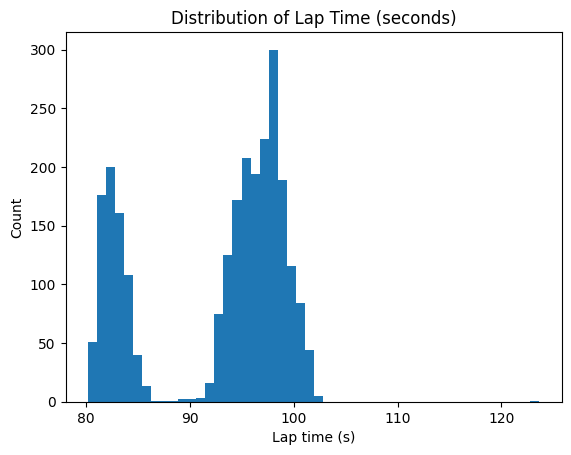

count    2512.000000
mean       92.660407
std         6.808468
min        80.235000
25%        83.995250
50%        95.444500
75%        97.853750
max       123.620000
Name: LapTimeSeconds, dtype: float64


In [9]:
plt.figure()
plt.hist(df["LapTimeSeconds"], bins=50)
plt.xlabel("Lap time (s)")
plt.ylabel("Count")
plt.title("Distribution of Lap Time (seconds)")
plt.show()

print(df["LapTimeSeconds"].describe())

<Figure size 640x480 with 0 Axes>

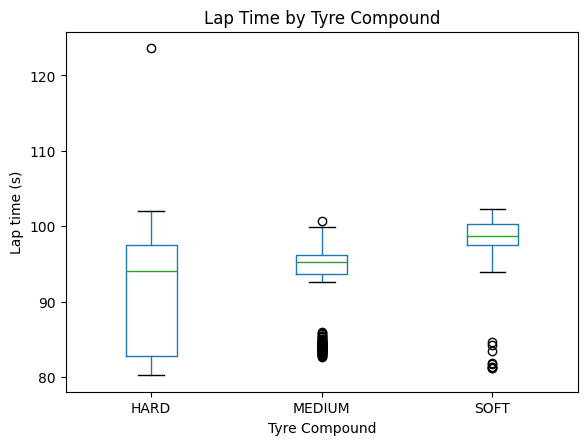

In [10]:
plt.figure()
df.boxplot(column="LapTimeSeconds", by="Compound", grid=False)
plt.xlabel("Tyre Compound")
plt.ylabel("Lap time (s)")
plt.title("Lap Time by Tyre Compound")
plt.suptitle("")
plt.show()

## 4) Modeling setup

Pipeline:
- One-hot encode categorical features (Driver, Compound)
- pass numeric features through as-is
- metrics: MAE and RMSE (seconds)

In [11]:
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

def evaluate(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    return {"label": label, "MAE": mae, "RMSE": rmse}

print("cat_cols:", cat_cols)
print("num_cols:", num_cols)

cat_cols: ['Driver', 'Compound']
num_cols: ['TyreLife', 'LapNumber', 'TyreLifeSquared']


## 5) Baseline (random split)

Start with a simple baseline: predict the mean lap time.  
This answers: “Do these features contain any predictive signal at all?”

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

dummy = Pipeline(steps=[
    ("prep", preprocess),
    ("model", DummyRegressor(strategy="mean"))
])

dummy.fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)

baseline_random = pd.DataFrame([
    evaluate(y_test, pred_dummy, "Baseline (Dummy mean, random split)")
])

baseline_random

,label,MAE,RMSE
0,"Baseline (Dummy mean, random split)",5.931055,6.793205


## 6) Why group split matters (key point)

A random split mixes laps from the same race into both train and test, which can be overly optimistic because conditions within a race are similar.

So I use a **group split by `EventName`**:
- train on two races
- test on one unseen race

This is a more realistic check of generalization to a new event/track.

In [13]:
df = df.reset_index(drop=True)
X  = X.reset_index(drop=True)
y  = y.reset_index(drop=True)

groups = df["EventName"].astype(str).to_numpy()

gss = GroupShuffleSplit(n_splits=1, test_size=0.33, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train_g = X.iloc[train_idx].copy()
X_test_g  = X.iloc[test_idx].copy()
y_train_g = y.iloc[train_idx].copy()
y_test_g  = y.iloc[test_idx].copy()

train_events = df.loc[train_idx, "EventName"].astype(str).unique()
test_events  = df.loc[test_idx, "EventName"].astype(str).unique()

print("Train events:", sorted(train_events))
print("Test events:", sorted(test_events))
print("Train size:", len(train_idx), "Test size:", len(test_idx))

Train events: ['Bahrain Grand Prix', 'Saudi Arabian Grand Prix']
Test events: ['Australian Grand Prix']
Train size: 1743 Test size: 769


## 7) Models

I compare:
- **Ridge Regression** (linear, simple, stable baseline)
- **Random Forest** (non-linear, can overfit when there are few races)

The point is to show that a more complex model is not automatically better.

In [14]:
ridge = Pipeline(steps=[
    ("prep", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

ridge.fit(X_train_g, y_train_g)
pred_ridge = ridge.predict(X_test_g)

In [15]:
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        max_depth=None
    ))
])

rf.fit(X_train_g, y_train_g)
pred_rf = rf.predict(X_test_g)

## 8) Results

I report:
- random split performance (often optimistic)
- group split performance (main result)

Interpretation focuses on the group split, since it tests “unseen race” generalization.

In [16]:
ridge.fit(X_train, y_train)
pred_ridge_random = ridge.predict(X_test)

split_compare = pd.DataFrame([
    evaluate(y_test,  pred_dummy,       "Dummy (random split)"),
    evaluate(y_test,  pred_ridge_random,"Ridge (random split)"),
    evaluate(y_test_g, pred_ridge,      "Ridge (group split)"),
]).sort_values("MAE")

split_compare

,label,MAE,RMSE
1,Ridge (random split),4.433845,5.289186
0,Dummy (random split),5.931055,6.793205
2,Ridge (group split),12.808299,12.932395


In [17]:
baseline_mean = y_train_g.mean()
pred_base_g = np.full(shape=len(y_test_g), fill_value=baseline_mean)

compare_tbl = pd.DataFrame([
    evaluate(y_test_g, pred_base_g, "Baseline (mean, group split)"),
    evaluate(y_test_g, pred_ridge, "Ridge (linear, group split)"),
    evaluate(y_test_g, pred_rf, "RandomForest (non-linear, group split)"),
]).sort_values("MAE")

compare_tbl

,label,MAE,RMSE
1,"Ridge (linear, group split)",12.808299,12.932395
2,"RandomForest (non-linear, group split)",12.949877,13.107307
0,"Baseline (mean, group split)",14.021920,14.142995


## 9) Sanity-check plot

A `true vs predicted` scatter plot helps visually inspect:
- systematic bias (under/over-prediction)
- large outliers

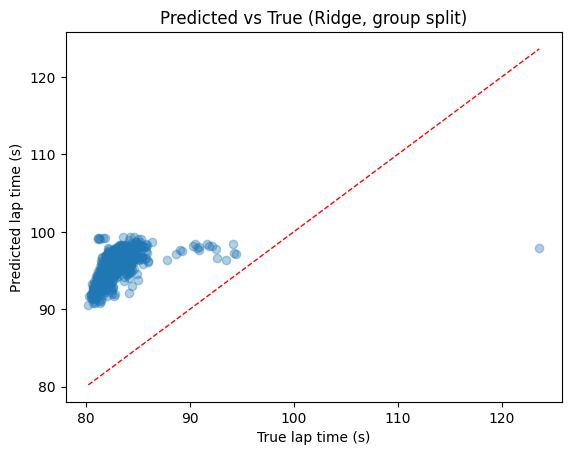

In [18]:
plt.figure()
plt.scatter(y_test_g, pred_ridge, alpha=0.35)
plt.xlabel("True lap time (s)")
plt.ylabel("Predicted lap time (s)")
plt.title("Predicted vs True (Ridge, group split)")
plt.plot([y_test_g.min(), y_test_g.max()],
         [y_test_g.min(), y_test_g.max()], 'r--', lw=1)
plt.show()

## 10) Error analysis (best model)

I break down absolute error to understand where the model struggles:
- by tyre compound
- by driver (top drivers by lap count)

I also keep track of sample size (number of laps), because small groups can produce noisy averages.

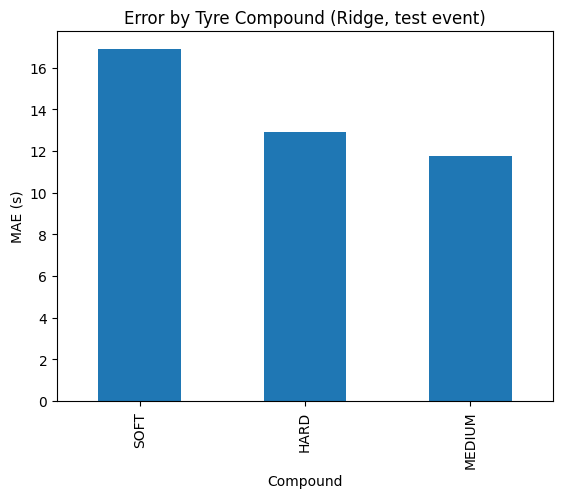

,MAE_seconds,n_laps
Compound,,
SOFT,16.887638,9
HARD,12.902884,667
MEDIUM,11.735163,93


In [19]:
err_df = df.iloc[test_idx].copy()
err_df["pred"] = pred_ridge
err_df["abs_error"] = (err_df["LapTimeSeconds"] - err_df["pred"]).abs()

comp = (err_df.groupby("Compound")["abs_error"]
        .agg(MAE_seconds="mean", n_laps="count")
        .sort_values("MAE_seconds", ascending=False))

comp["MAE_seconds"].plot(kind="bar")
plt.ylabel("MAE (s)")
plt.title("Error by Tyre Compound (Ridge, test event)")
plt.show()

comp

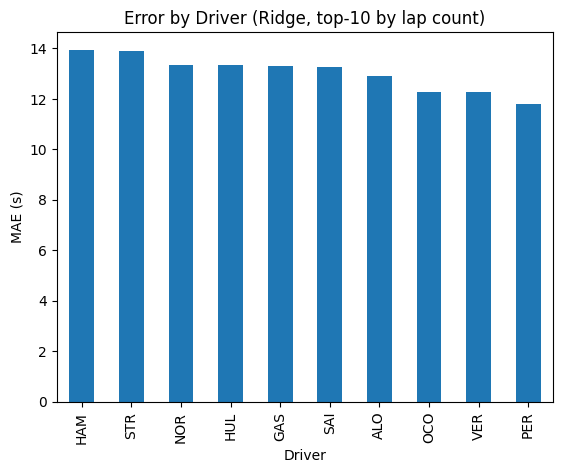

,MAE_seconds,n_laps
Driver,,
ALO,12.900918,45
HAM,13.944269,45
GAS,13.317854,45
VER,12.279171,45
STR,13.881415,45
HUL,13.332298,45
NOR,13.354215,45
PER,11.810202,45
OCO,12.285757,45


In [20]:
drv = (err_df.groupby("Driver")["abs_error"]
       .agg(["mean", "count"])
       .sort_values("count", ascending=False)
       .head(10))

drv["mean"].sort_values(ascending=False).plot(kind="bar")
plt.ylabel("MAE (s)")
plt.title("Error by Driver (Ridge, top-10 by lap count)")
plt.show()


drv = drv.rename(columns={"mean": "MAE_seconds", "count": "n_laps"})
drv

## 11) Feature importance (interpretability)

For Random Forest, feature importances provide a rough view of which inputs are most used by the model.
This is not a causal statement — just an interpretability aid.

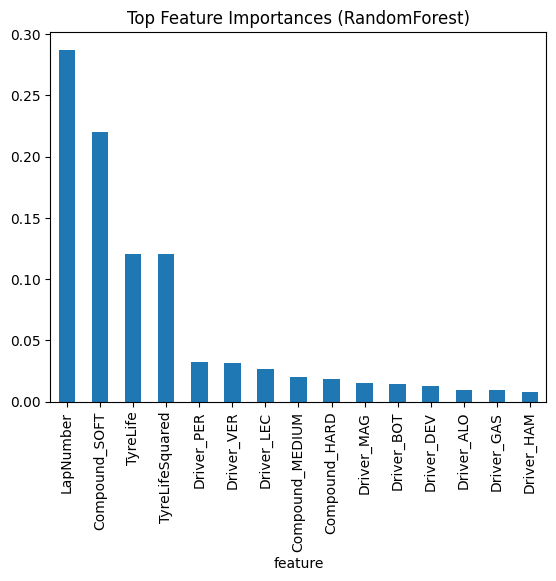

,feature,importance
24,LapNumber,0.287334
22,Compound_SOFT,0.219674
23,TyreLife,0.120405
25,TyreLifeSquared,0.120159
11,Driver_PER,0.032650
18,Driver_VER,0.031532
7,Driver_LEC,0.026627
21,Compound_MEDIUM,0.019867
20,Compound_HARD,0.018104
8,Driver_MAG,0.015446


In [21]:
ohe = rf.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
feature_names = cat_feature_names + num_cols

importances = rf.named_steps["model"].feature_importances_
fi = (pd.DataFrame({"feature": feature_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .head(15))

fi.set_index("feature")["importance"].plot(kind="bar")
plt.title("Top Feature Importances (RandomForest)")
plt.show()

fi

## Summary & takeaways

### Results

Under a random split, both models significantly outperform the baseline.
However, performance drops substantially when evaluated using a group-based split (train on two races, test on one unseen race).

This confirms that random splits can produce overly optimistic estimates when laps from the same event appear in both training and test sets.

Under the more realistic unseen-race evaluation:

- Ridge achieved MAE ≈ 12.8 s  
- RandomForest achieved MAE ≈ 13.0 s  

Interestingly, the simpler linear model slightly outperformed the non-linear model.
With only a few races available, Ridge generalized more reliably, while RandomForest likely captured event-specific patterns.

### What this project demonstrates:

- construction of a full ML pipeline from raw data to evaluation
- proper validation using group-based splitting
- comparison of linear and non-linear models
- structured error analysis across drivers and tyre compounds
- basic interpretability using feature importance

### Limitations

Lap time depends on many additional factors not included here, such as traffic, fuel load, safety car periods, and race strategy.
With only three races, results are sensitive to which event is used as the test set.

The main insight is not the absolute error value, but the importance of realistic validation and careful interpretation.

